# Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import os
import sys
import shutil
import skimage.io as io

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
COCO_ROOT = './data/'
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Sourse ds
http://images.cocodataset.org/zips/train2017.zip<br>
http://images.cocodataset.org/zips/val2017.zip<br>
http://images.cocodataset.org/annotations/annotations_trainval2017.zip<br>

https://github.com/cocodataset/cocoapi

## Select imgs

In [3]:
def select_files_COCO(sourse, sublist):
    ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', f'instances_{sublist}2017.json')
    coco = COCO(ann_file_fpath)
    cat_ids = coco.getCatIds(catNms=['person'])
    img_list = coco.getImgIds(catIds=cat_ids)
    
    fname_list = [coco.loadImgs(img)[0]['coco_url'].split('/')[-1] for img in img_list]
    
    path = f'./data/{sublist}2017/'
    if not os.path.exists(f'./data/{sublist}2017/'):
        os.mkdir(path)
    
    for file in os.listdir(sourse):
        if file in fname_list:
            shutil.copy(sourse + file, path + file)
            
    print(f'file count: {len(os.listdir(path))}')

In [4]:
%%time
# select_files_COCO(sourse='./val2017/', sublist='val')
# select_files_COCO(sourse='./train2017/', sublist='train')

Wall time: 0 ns


# Prep ds

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, epochs, batch_size, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
INP_SIZE = 256
BATCH_SIZE = 8
NUM_EPOCHS = 1

COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

loading annotations into memory...
Done (t=21.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


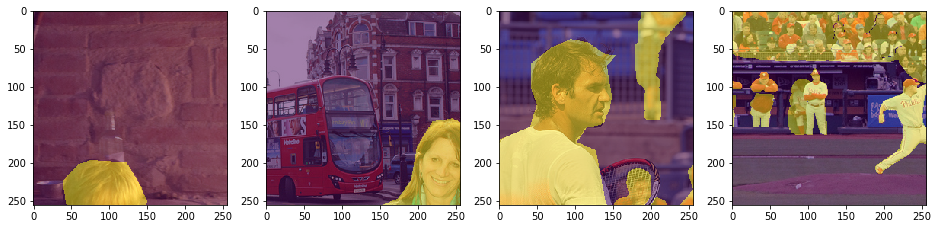

In [8]:
img, mask = next(iter(train_ds.take(1)))

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[i])
    plt.imshow(mask[i, ..., 0], alpha=0.5)

# Model

In [9]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = layers.MaxPool2D((2, 2))(out1)

    out = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = layers.MaxPool2D((2, 2))(out2)

    out = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = layers.MaxPool2D((2, 2))(out3)

    out = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = layers.MaxPool2D((2, 2))(out4)

    out = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

In [10]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model = build_model()

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['accuracy']
)

## Checkpoint

In [11]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

Latest checkpoint restored!


# Training

In [12]:
%%time

if 0:
    hist = model.fit(
        train_ds,
        validation_data=val_ds
    )

 170/8014 [..............................] - ETA: 43:50:51 - loss: 0.3943 - accuracy: 0.83 - ETA: 2:16:37 - loss: 0.4897 - accuracy: 0.7750 - ETA: 2:16:40 - loss: 0.5094 - accuracy: 0.758 - ETA: 2:16:46 - loss: 0.5001 - accuracy: 0.762 - ETA: 2:16:53 - loss: 0.4939 - accuracy: 0.766 - ETA: 2:17:14 - loss: 0.4878 - accuracy: 0.770 - ETA: 2:17:34 - loss: 0.4776 - accuracy: 0.776 - ETA: 2:17:59 - loss: 0.4671 - accuracy: 0.782 - ETA: 2:18:25 - loss: 0.4584 - accuracy: 0.787 - ETA: 2:18:49 - loss: 0.4523 - accuracy: 0.791 - ETA: 2:18:43 - loss: 0.4458 - accuracy: 0.794 - ETA: 2:18:32 - loss: 0.4408 - accuracy: 0.797 - ETA: 2:18:23 - loss: 0.4367 - accuracy: 0.799 - ETA: 2:18:33 - loss: 0.4337 - accuracy: 0.801 - ETA: 2:18:45 - loss: 0.4315 - accuracy: 0.802 - ETA: 2:18:54 - loss: 0.4296 - accuracy: 0.803 - ETA: 2:19:01 - loss: 0.4276 - accuracy: 0.804 - ETA: 2:18:55 - loss: 0.4256 - accuracy: 0.805 - ETA: 2:19:01 - loss: 0.4236 - accuracy: 0.806 - ETA: 2:18:53 - loss: 0.4217 - accuracy: 0.

 340/8014 [>.............................] - ETA: 2:20:08 - loss: 0.3966 - accuracy: 0.817 - ETA: 2:20:10 - loss: 0.3966 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3966 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3966 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3966 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3967 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:10 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:10 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:11 - loss: 0.3968 - accuracy: 0.817 - ETA: 2:20:12 - loss: 0.3969 - accuracy: 0.8

 386/8014 [>.............................] - ETA: 2:32:31 - loss: 0.3986 - accuracy: 0.815 - ETA: 2:32:28 - loss: 0.3986 - accuracy: 0.815 - ETA: 2:32:24 - loss: 0.3986 - accuracy: 0.815 - ETA: 2:32:21 - loss: 0.3986 - accuracy: 0.815 - ETA: 2:32:18 - loss: 0.3986 - accuracy: 0.815 - ETA: 2:32:15 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:32:12 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:32:09 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:32:07 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:32:04 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:32:01 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:31:58 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:31:55 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:31:53 - loss: 0.3987 - accuracy: 0.815 - ETA: 2:31:50 - loss: 0.3988 - accuracy: 0.815 - ETA: 2:31:48 - loss: 0.3988 - accuracy: 0.815 - ETA: 2:31:45 - loss: 0.3988 - accuracy: 0.815 - ETA: 2:31:42 - loss: 0.3988 - accuracy: 0.815 - ETA: 2:31:39 - loss: 0.3988 - accuracy: 0.815 - ETA: 2:31:36 - loss: 0.3988 - accuracy: 0.8

KeyboardInterrupt: 

In [13]:
ckpt_manager.save()

'./checkpoints/train\\ckpt-8'

In [14]:
train_loss, train_accuracy = model.evaluate(train_ds.take(1))
test_loss, test_accuracy = model.evaluate(val_ds.take(1))

1/1 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.86 - 3s 3s/step - loss: 0.3337 - accuracy: 0.8692


In [15]:
print(f'train loss: {train_loss:.4f} | train accuracy: {train_accuracy:.4f}')
print(f'test loss: {test_loss:.4f} | test accuracy: {test_accuracy:.4f}')

train loss: 0.3934 | train accuracy: 0.7973
test loss: 0.3337 | test accuracy: 0.8692


## View train pred

In [16]:
train_x, train_y = next(iter(train_ds))
val_x, val_y = next(iter(val_ds))

Wall time: 20.2 s


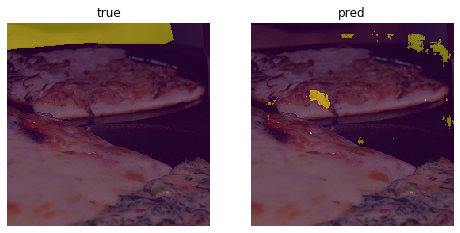

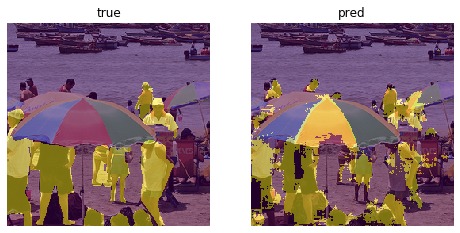

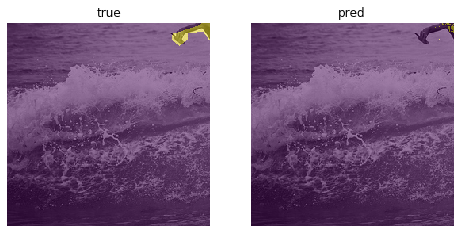

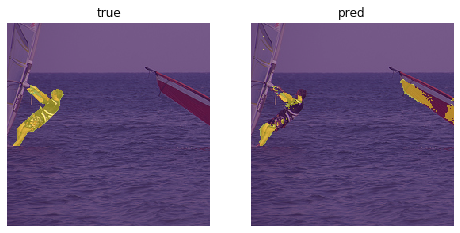

In [26]:
%%time
PERCEPTION = 0.5

pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

## View val pred

Wall time: 4.52 s


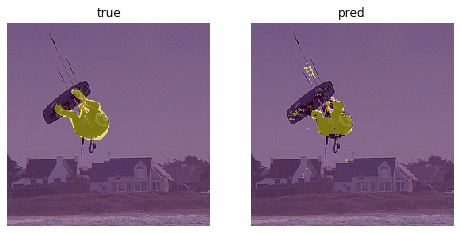

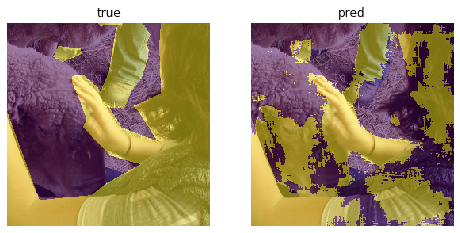

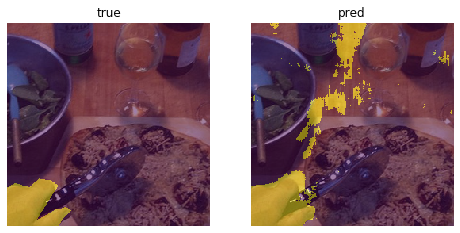

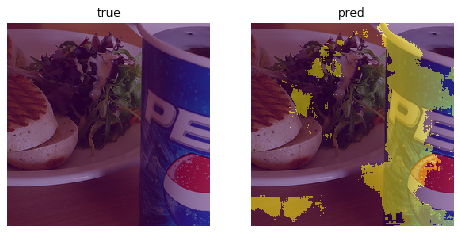

In [27]:
%%time
pred_prob = model(val_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(val_x[i])
    plt.imshow(val_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(val_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')